In [8]:
import amlutils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [9]:
tf.__version__

'2.1.0'

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True

## Parse Training Data

In [11]:
csv_file = "./data/Top30.csv"
csv_data = amlutils.csv_utils.parse_csv_file(csv_file, quotechar='"', encoding="latin-1")
headers = csv_data[0]
csv_data = csv_data[1:]
print(headers)
print(len(csv_data))

['', 'Unnamed: 0', 'Query', 'Description']
72292


In [12]:
import re
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

def stripnewlinechars(data):
    data = data.replace(r"\n", "")
    data = data.replace(r"\r", "")
    return data


In [13]:
job_description_index = headers.index("Description")
job_title_index = headers.index("Query")
job_titles = [row[job_title_index] for row in csv_data]
job_descriptions = [row[job_description_index] for row in csv_data]
no_html_tags_descriptions = [striphtml(desc) for desc in job_descriptions]


## Ensure there is no Job Title in description

In [14]:
no_label_in_descriptions= [
    desc.replace(job_titles[i], "") for i, desc in enumerate(no_html_tags_descriptions)
]
no_html_tags_descriptions[0], no_label_in_descriptions[0]

('This Administrative Assistant position is responsible for performing a variety of clerical and administrative support functions in the areas of communications, data entry and retrieval, typing, filing, copying, and coordination of related administrative activities. \\r\\n\\r\\nJOB REQUIREMENTS:\\r\\nAttention to detail\\r\\nAbility to work in a fast paced environment\\r\\nInvoicing\\r\\nProficient in Word, Excel and Outlook\\r\\nOther Administrative responsibilities as needed.\\r\\n\\r\\nQUALIFICATIONS:\\r\\nHigh School Diploma\\r\\nAdministrative Assistant Experience\\r\\n1-2 Years work experience\\r\\nWorking knowledge of all basic office machines (fax, copier, 10key, etc.)\\r\\nStrong verbal and written communication skills\\r\\nStrong work ethic.',
 'This  position is responsible for performing a variety of clerical and administrative support functions in the areas of communications, data entry and retrieval, typing, filing, copying, and coordination of related administrative act

In [16]:
classes = set(job_titles)
num_clasess = len(classes)
vocabulary_size = 5000
num_samples = len(job_titles)

class_str_to_index = {label: index for index, label in enumerate(classes)}
index_to_class = {index: label for label, index in class_str_to_index.items()}

# convert string labels to integer indices for training
job_titles_indexed = [class_str_to_index[job_title] for job_title in job_titles]
print(f"Num Classes: {len(classes)}, Num Samples: {num_samples}")

Num Classes: 30


In [18]:
text_tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocabulary_size
)
text_tokenizer.fit_on_texts(no_label_in_descriptions)
train_sequences = text_tokenizer.texts_to_sequences(no_html_tags_descriptions)

In [19]:
index = 100
subset_train_sequences, subset_job_titles = train_sequences[:index], job_titles_indexed[:index]

In [73]:
batch_size = 64
dataset = tf.data.Dataset.from_generator(
    lambda: zip(train_sequences, job_titles_indexed),
    output_types=(tf.int32, tf.int32),
)

dataset = dataset.shuffle(100000).map(
    lambda features, label: (features, label)
).padded_batch(
    batch_size=batch_size,
    padded_shapes=((None,), ()),
).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)


In [74]:
num_train_samples = int(0.8 * num_samples // batch_size)
num_test_samples = num_samples // batch_size - num_train_samples
print(num_train_samples, num_test_samples)

903 226


In [75]:
train_dataset = dataset.take(num_train_samples)
test_dataset = dataset.skip(num_train_samples)

In [76]:
len(list(test_dataset.as_numpy_iterator()))

227

In [77]:
# list(train_dataset.as_numpy_iterator())

In [78]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabulary_size, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_clasess)   
])

In [79]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                990       
Total params: 179,710
Trainable params: 179,710
Non-trainable params: 0
_________________________________________________________________


In [99]:
history = model.fit(
    train_dataset,
    epochs=2,
)

Epoch 1/2
903/903 [==============================] - 424s 469ms/step - loss: 0.3293 - accuracy: 0.9104
Epoch 2/2
903/903 [==============================] - 469s 519ms/step - loss: 0.2926 - accuracy: 0.9192


## Evaluation on Random Sample

In [100]:
import random
index = random.randint(0, len(job_titles_indexed)-1)
description = no_label_in_descriptions[index]
description_sequence = text_tokenizer.texts_to_sequences([description])
label = model.predict(description_sequence)
softmax_labels = tf.nn.softmax(label)
print(index, job_titles_indexed[index], index_to_class[job_titles_indexed[index]], tf.math.argmax(softmax_labels, axis=1))

# print(description, description_sequence, )

48525 13 Inside Sales Representative tf.Tensor([13], shape=(1,), dtype=int64)


## Evaluation on Test Dataset

In [101]:
gts = []
predictions = []
for batch in test_dataset:
    features, gt = batch
    prediction = model.predict_classes(features)
    gts.extend(gt)
    predictions.extend(prediction)
len(gts), len(predictions)

(14500, 14500)

In [102]:
accuracy = tf.keras.metrics.Accuracy()
accuracy(gts, predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=0.92255175>

In [103]:
total_correct = 0
total_incorrect = 0
for i in range(len(gts)):
    if gts[i] == predictions[i]:
        total_correct += 1
    else:
        total_incorrect += 1
print(total_correct, total_incorrect, total_correct/(total_correct + total_incorrect))

13377 1123 0.9225517241379311


## Plotting

In [132]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric])
    plt.show()

In [135]:
history.history["accuracy"]

[0.9103509, 0.91915834]

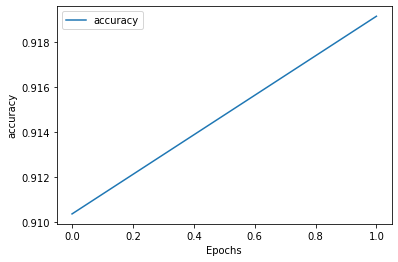

In [133]:
plot_graphs(history, "accuracy")